In [3]:
%matplotlib inline
# %matplotlib notebook
import numpy as np
from mpl_tools import is_notebook_or_qt as nb

In [4]:
import dapper as dpr
import dapper.da_methods as da
import dapper.mods as modelling
import dapper.mods.Lorenz96 as core
import dapper.tools.liveplotting as LP

In [5]:
# #### Augmented dynamics

# Dims of state and parameter
Nx = 40
Np = 1

In [6]:
# Wrap core.dxdt so as to process an "augmented" state vector
# that also contains parameter values.
@modelling.ens_compatible
def dxdt_augmented(x):
    d = np.full_like(x, np.nan)     # Allocate. Use nan's to detect bugs.
    core.Force = x[Nx:].T           # Set param
    d[:Nx] = core.dxdt(x[:Nx].T).T  # Dynamics
    d[Nx:] = 0                      # No dynamics ("persistence") for param.
    return d

In [7]:
# Note that the Force is a module-level variable,
# that gets set repeatedly during the course of the assimilation.
# This seems like it could easily lead to bugs.
# A more robust approach would be if the Force was part of the
# input arguments of `core.dxdt`. This could be achieved, for example, by
# - re-writing core.dxdt so to process the augmented vector
#   `[x, Force]` as the state variable.
# - enclosing `dxdt` in an outer function which binds the value of the Force
# - creating `dxdt` in an outer "factory" function which determines the
#   shape and allocation of the input vector to dxdt.
# - Do the latter using OOP. This would probably be more verbose,
#   but even more flexible. In particular, OOP excels at working with multiple
#   realisations of models at the same time. However, when using ensemble methods,
#   the number of realisations, and the required level of automation
#   (input vector/ensemble --> output vector/ensemble) is very high.
#   It is not immediately clear if OOP is then more convenient.
# - There are also some intriguing possibilities relating to namedtuples.
# TODO 4: revise the above text.


In [8]:
# Turn dxdt into `step` such that `x_{k+1} = step(x_k, t, dt)`
step = modelling.with_rk4(dxdt_augmented, autonom=True)

In [9]:
# #### HMM

# Define the sequence of the experiment
# See `modelling.Chronology` for more details.
tseq = modelling.Chronology(
    dt=0.05,     # Integrational time step
    dko=1,     # Steps of duration dt between obs
    Ko=10**3,  # Total number of obs in experiment
    BurnIn=5,    # Omit from averages the period t=0 --> BurnIn
    Tplot=7)     # Default plot length

In [10]:
# Define dynamical model
Dyn = {
    'M': Nx+Np,     # Length of (total/augmented) state vector
    'model': step,  # Actual model
    'noise': 0,     # Additive noise (variance)
    # 'noise': GaussRV(C=.1*np.eye(Nx+Np)),
}

In [11]:
# Define observation model using convenience function partial_Id_Obs
jj = np.arange(Nx)  # obs indices (y = x[jj])
Obs = modelling.partial_Id_Obs(Nx+Np, jj)
Obs['noise'] = 1

In [12]:
# Specify liveplotting (and replay) functionality.
LP = [
    (1, LP.spatial1d(jj)),
    (1, LP.sliding_marginals(
        jj, zoomy=0.8, dims=[0, Nx], labels=["$x_0$", "Force"]),
     ),
]

In [13]:
# Labels for sectors of state vector.
# DAPPER will compute diagnostic statistics for the full state vector,
# but also for each sector of it (averaged in space according to the
# methods specified in your .dpr_config.yaml:field_summaries key).
# The name "sector" comes from its typical usage to distinguish
# "ocean" and "land" parts of the state vector.
# Here we use it to get individual statistics of the parameter and state.
parts = dict(state=np.arange(Nx),
             param=np.arange(Np)+Nx)

In [14]:
# Wrap-up model specification
HMM = modelling.HiddenMarkovModel(Dyn, Obs, tseq, sectors=parts, LP=LP)

In [16]:
# #### Treat truth and DA methods differently

# Bocquet et al. do not sample the true parameter value from the
# Bayesian (random) prior / initial cond's (ICs), given to the DA methods.
# Instead it is simply set to 8.

TRUTH = 8
GUESS = 7

In [17]:
# Seeing how far off the intial guess (and its uncertainty, defined below)
# is from the truth, this constitutes a kind of  model error.
# It is not a feature required to make this experiment interesting.
# However, our goal here is to reproduce the results of Bocquet et al.,
# so we will follow suit.
#
# PS: It often doesn't matter (for the time-averaged statistics)
# what exact ICs are in play as long as the BurnIn is sufficiently large.
# However, the setup defined here does make for pretty plots
# at the beginning of the experiment.

In [18]:
# Let's define the prior/ICs as a Gaussian with diagonal covariance,
# where the last part of the diagonal (corresponding to the parm.
# component of the state vector) may be specified as an argument...
def X0(param_mean, param_var):
    # State
    x0 = np.zeros(Nx)
    C0 = .01*np.ones(Nx)
    # Append param params
    x0 = np.hstack([x0, param_mean*np.ones(Np)])
    C0 = np.hstack([C0, param_var*np.ones(Np)])
    return modelling.GaussRV(x0, C0)

In [19]:
# ... Thus we can distinguish between the behaviour of the truth simulation,
# and the dynamics for the DA methods.
def set_X0_and_simulate(hmm, xp):
    dpr.set_seed(3000)
    hmm.X0 = X0(TRUTH, 0)
    xx, yy = hmm.simulate()
    hmm.X0 = X0(GUESS, 0.1**2)
    return hmm, xx, yy

In [20]:
# Note: An alternative approach might be to simply
# write our own `simulate()` which merely sets the `Force` parameter,
# rather than sampling it.

In [21]:
# #### DA methods configurations

xps = dpr.xpList()
# xps += da.PartFilt(N=1000, reg=1)  # works OK with Nx=6
for N in [20, 50]:
    # xps += da.EnKF('Sqrt', N, infl=1.04)
    xps += da.EnKF_N(N, xN=2)
    for Lag in [1, 4, 20]:
        xps += da.iEnKS("Sqrt", N, Lag=Lag, xN=2, wtol=1e-5)
# TODO 4: Add 3D- and 4D-Var

In [22]:
# #### Launch experiments

scriptname = "basic_3" if nb else __file__
save_as = xps.launch(
    HMM, scriptname, setup=set_X0_and_simulate,
    mp=False,           # Multiprocessing
    fail_gently=False,  # Facilitate debugging
    liveplots=False,    # NB: Turn off if running iEnKS
    free=False,         # Don't delete time series (enables replay)
)

Experiment gets stored at /home/dgrund/dpr_data/basic_3/run_2024-01-03__12-32-47


Truth & Obs:   0%|          | 0/1001 [00:00<?, ?it/s]

EnKF_N N:20:   0%|          | 0/1001 [00:00<?, ?it/s]

Truth & Obs:   0%|          | 0/1001 [00:00<?, ?it/s]

iEnKS N:20 Lag:1:   0%|          | 0/1002 [00:00<?, ?it/s]

Truth & Obs:   0%|          | 0/1001 [00:00<?, ?it/s]

iEnKS N:20 Lag:4:   0%|          | 0/1005 [00:00<?, ?it/s]

Truth & Obs:   0%|          | 0/1001 [00:00<?, ?it/s]

iEnKS N:20 Lag:20:   0%|          | 0/1021 [00:00<?, ?it/s]

Truth & Obs:   0%|          | 0/1001 [00:00<?, ?it/s]

EnKF_N N:50:   0%|          | 0/1001 [00:00<?, ?it/s]

Truth & Obs:   0%|          | 0/1001 [00:00<?, ?it/s]

iEnKS N:50 Lag:1:   0%|          | 0/1002 [00:00<?, ?it/s]

Truth & Obs:   0%|          | 0/1001 [00:00<?, ?it/s]

iEnKS N:50 Lag:4:   0%|          | 0/1005 [00:00<?, ?it/s]

Truth & Obs:   0%|          | 0/1001 [00:00<?, ?it/s]

iEnKS N:50 Lag:20:   0%|          | 0/1021 [00:00<?, ?it/s]

In [23]:
# #### Show results

# Load data
xps = dpr.xpList(dpr.load_xps(save_as))

Loading 8 files from /home/dgrund/dpr_data/basic_3/run_2024-01-03__12-32-47


Loading:   0%|          | 0/8 [00:00<?, ?it/s]

In [24]:
# These scores may be validated by cross-checking with those
# reported by bib.bocquet2013joint in their ...
print(xps.tabulate_avrgs([
    "rmse.state.a", "rmv.state.a",  # ... figure 6, and
    "rmse.param.a", "rmv.param.a",  # ... figure 7.
]))

   da_method   N  Lag  |  rmse.state.a  1σ     rmv.state.a  1σ     rmse.param.a  1σ      rmv.param.a  1σ    
-  ---------  --  ---  -  -------------------  ------------------  --------------------  -------------------
0  EnKF_N     20       |         0.178 ±0.004        0.197 ±0.003        0.014  ±0.004        0.018  ±0.004 
1  iEnKS      20    1  |         0.172 ±0.004        0.193 ±0.003        0.013  ±0.003        0.0167 ±0.0008
2  iEnKS      20    4  |         0.168 ±0.004        0.189 ±0.003        0.015  ±0.003        0.016  ±0.002 
3  iEnKS      20   20  |         0.156 ±0.004        0.186 ±0.003        0.007  ±0.001        0.016  ±0.002 
4  EnKF_N     50       |         0.171 ±0.004        0.183 ±0.004        0.007  ±0.002        0.010  ±0.001 
5  iEnKS      50    1  |         0.164 ±0.004        0.179 ±0.003        0.006  ±0.001        0.009  ±0.001 
6  iEnKS      50    4  |         0.154 ±0.004        0.171 ±0.003        0.0039 ±0.0006       0.0082 ±0.0009
7  iEnKS      50   

In [ ]:
# Note that only the data points at `Lag` (data assimilation window length) 0 and
# 1 are reproduced by DAPPER, because the IEnKS in DAPPER does not have MDA
# (in the same sense as bib.bocquet2013joint), which applies for `Lag>=2`.
# Nevertheless, DAPPER's IEnKS accuracy also improves (both for state and param)
# with increasing Lag. However, `Lag=100` is too much (causes divergence)
# without the MDA component of by Bocquet et al.

IndexError: index 40 is out of bounds for axis 1 with size 2

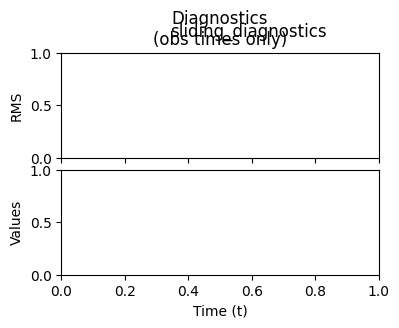

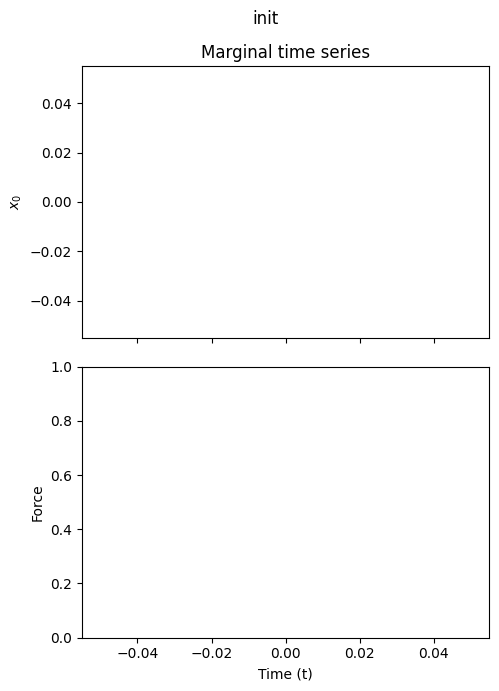

In [25]:
# Plots
xps[-1].stats.replay(
    # t1=0,
    # t2=np.inf,
)